In [1]:
import json

In [2]:
import numpy as np
import scipy.stats as scs
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.metrics import (precision_recall_fscore_support,
                             roc_auc_score,
                             precision_recall_curve,
                             average_precision_score,
                             roc_curve)
from sklearn.externals import joblib
from sklearn.base import clone
from sklearn.neighbors import KNeighborsClassifier
np.random.seed(369)
from scipy.interpolate import BSpline, splrep, make_interp_spline

In [4]:
from frag_tools import (DropColumns,
                        AddressLatLong,
                        CurrentMakeDummies,
                        Binarize,
                        ChangeTypes,
                        custom_zip_cleaning)
from various_tools import (roc,
                           plot_roc,
                           cross_val_metrics,
                           make_metric_df)

In [5]:
df = pd.read_csv('/mnt/c/Users/kurtrm/Downloads/Predictive_Maintenance_Transformer_Overload_PA.csv', sep=';')

In [6]:
pipe = make_pipeline(CurrentMakeDummies(['Manufacturer',
                                         'Repairs',
                                         'Overloads',
                                         'AssetType']),
                     ChangeTypes(['Age', 'AssetZip'],
                                 [lambda x: float(x.replace(',', '.')),
                                  custom_zip_cleaning]),
                     Binarize(['VegMgmt',
                               'PMLate',
                               'WaterExposure',
                               'MultipleConnects',
                               'Storm']),
                     AddressLatLong(),
                     DropColumns(['AssetCity',
                                  'AssetId',
                                  'AvgRepairCost',
                                  'AssetState',
                                  'MilesFromOcean',
                                  'AssetLocation',
                                  'locationID',
                                  'Latitude1',
                                  'Longitude1',
                                  'Latitude',
                                  'Longitude',
                                  'Overloads_Below 100%',
                                  'Overloads_100-120%',
                                  'Overloads_120-150%',
                                  'Overloads_Above 150%',
                                  'AssetZip']))
transformed = pipe.fit_transform(df)

In [7]:
transformed.columns

Index(['VegMgmt', 'PMLate', 'WaterExposure', 'MultipleConnects', 'Storm',
       'Age', 'Status', 'Manufacturer_GE', 'Manufacturer_Other',
       'Manufacturer_Schneider Electric', 'Manufacturer_Siemens',
       'Repairs_Original', 'Repairs_Rebuild+1', 'Repairs_Rebuild+2',
       'Repairs_Rebuild+3', 'AssetType_1-Phase Pole Transformer',
       'AssetType_3-Phase Transformer', 'AssetType_DF-series Transformer',
       'AssetType_Padmount Transformer', 'AssetType_Voltage Transformer'],
      dtype='object')

In [8]:
X_train, X_test, y_train, y_test = train_test_split(transformed.drop('Status', axis=1).values, transformed['Status'].values, test_size=.2)

In [9]:
_, gbc_final = joblib.load('refined_models.pkl')

In [10]:
gbc_final.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.005, loss='deviance', max_depth=5,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              presort='auto', random_state=None, subsample=0.5, verbose=0,
              warm_start=False)

In [11]:
probs = gbc_final.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probs[:, 1])

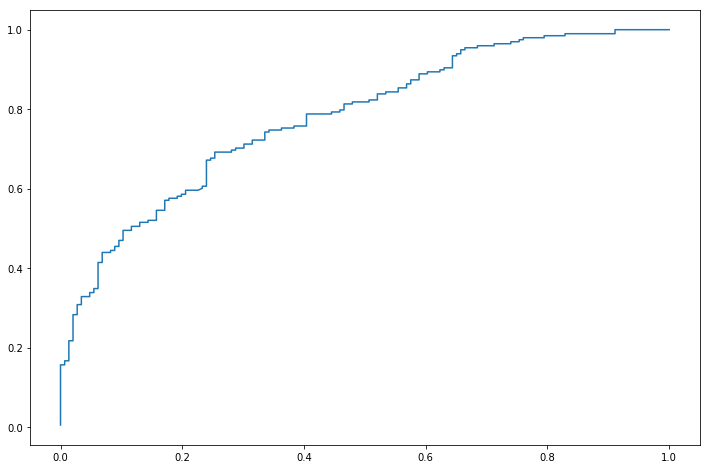

In [12]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(fpr, tpr)

In [13]:
roc_auc_score(y_test, probs[:, 1])

0.77980143904801436

In [14]:
line = np.linspace(0, 1, len(thresholds))

In [15]:
listy = []
for fp, tp, thresh, lin in zip(fpr, tpr, thresholds, line):
    listy.append({'fpr': fp, 'tpr': tp, 'thresh': thresh, 'lin': lin})

In [16]:
with open('../src/static/data/roc_data.json', 'w') as f:
    json.dump(listy, f)

In [17]:
joblib.dump(gbc_final, '../src/static/models/final_grad_boost.pkl')

['../src/static/models/final_grad_boost.pkl']

In [18]:
def threshold_prediction(model, X, threshold=0.5):
    """
    Return predictions based on threshold.
    """
    return np.where(model.predict_proba(X)[:, 1] > threshold,
                    model.classes_[1],
                    model.classes_[0])

def confusion_matrix(model, X_test, y_test, threshold=0.5):
    cf = pd.crosstab(y_test, threshold_prediction(model, X_test, threshold))
    cf.index.name = 'actual'
    cf.columns.name = 'predicted'
    return cf.values

In [19]:
cf = confusion_matrix(gbc_final, X_test, y_test, .5)
costs = np.array([[-5, -20], [5, 10]])

In [20]:
def calculate_payout(cb_matrix, model, X, y, threshold):
    return (confusion_matrix(model, X, y, threshold) * cb_matrix).sum()

Text(0.5,0,'thresholds')

Text(0,0.5,'losses')

Text(0.5,1,'Profit Curve')

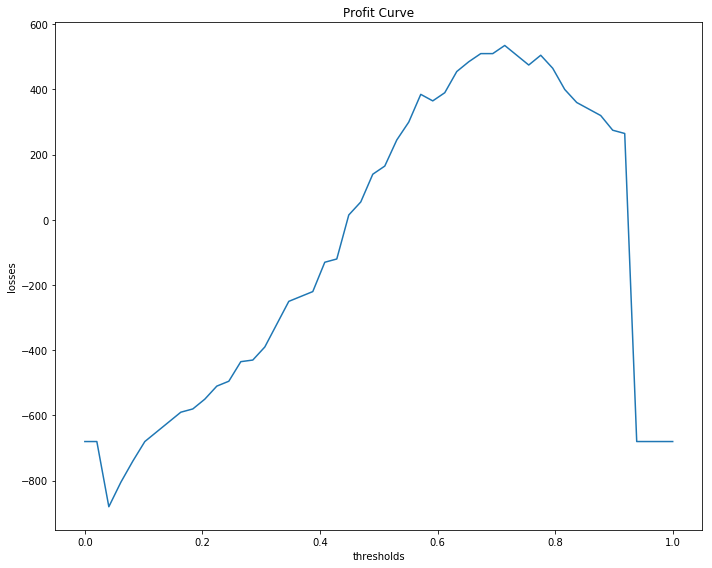

In [21]:
gen_thresholds = np.linspace(0, 1, 50)

fig, ax = plt.subplots(figsize=(10, 8))

profits = []
for thr in gen_thresholds:
    profits.append(calculate_payout(costs, gbc_final, X_test, y_test, thr))
ax.plot(gen_thresholds, np.array(profits))
ax.set_xlabel('thresholds')
ax.set_ylabel('losses')
ax.set_title('Profit Curve')
fig.tight_layout()

In [22]:
splrep(gen_thresholds, np.array(profits))

(array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.04081633,
         0.06122449,  0.08163265,  0.10204082,  0.12244898,  0.14285714,
         0.16326531,  0.18367347,  0.20408163,  0.2244898 ,  0.24489796,
         0.26530612,  0.28571429,  0.30612245,  0.32653061,  0.34693878,
         0.36734694,  0.3877551 ,  0.40816327,  0.42857143,  0.44897959,
         0.46938776,  0.48979592,  0.51020408,  0.53061224,  0.55102041,
         0.57142857,  0.59183673,  0.6122449 ,  0.63265306,  0.65306122,
         0.67346939,  0.69387755,  0.71428571,  0.73469388,  0.75510204,
         0.7755102 ,  0.79591837,  0.81632653,  0.83673469,  0.85714286,
         0.87755102,  0.89795918,  0.91836735,  0.93877551,  0.95918367,
         1.        ,  1.        ,  1.        ,  1.        ]),
 array([ -680.        ,  -457.69992236, -1024.60015527,  -779.76643376,
         -747.54254007,  -670.06340596,  -652.20383608,  -621.12124971,
         -583.31116507,  -585.63409003,  -554.15247483,  -497.75

In [23]:
splines = BSpline(*splrep(gen_thresholds, np.array(profits)))

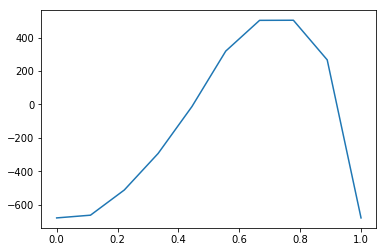

In [24]:
plt.plot(np.linspace(0, 1, 10), splines(np.linspace(0, 1, 10), extrapolate=False))

In [25]:
# roc_splines = BSpline(*splrep(fpr_new, tpr_new))
# plt.plot(np.linspace(0, 1, 10), roc_splines(np.linspace(0, 1,10), extrapolate=False))

In [26]:

def sum_payout(cost_matrix, confusion_matrix):
    """
    Calculate the profit from cost and confusion matrices.
    """
    return (confusion_matrix * cost_matrix).sum()

In [27]:
def generate_profit_curve(cost_matrix,
                          model,
                          X_test, y_test, n_thresholds=100):
    """
    Generate the profit curve with a given cost matrix.
    """
    thresholds = np.linspace(0, 1, n_thresholds)
    totals = []
    for threshold in thresholds:
        iter_conf_matrix = confusion_matrix(model, X_test, y_test, threshold)
        totals.append(sum_payout(cost_matrix, iter_conf_matrix))

    return thresholds, np.array(totals)

In [28]:
def diff_generate_profit_curve(cost_matrix,
                               model,
                               X_test, y_test, n_thresholds=100):
    """
    Generate the profit curve with a given cost matrix.
    """
    thresholds = np.linspace(0, 1, n_thresholds)
    totals = np.empty(n_thresholds)
    for i, threshold in enumerate(thresholds):
        iter_conf_matrix = confusion_matrix(model, X_test, y_test, threshold)
        totals[i] = sum_payout(cost_matrix, iter_conf_matrix)

    return thresholds, totals